[![UAEM](https://www.uaem.mx/fcaei/images/uaem.png)](https://www.uaem.mx/fcaei/moca.html)
[![Google OR-Tools](https://img.shields.io/badge/Google%20OR--Tools-8A2BE2.svg)](https://developers.google.com/optimization)
[![Python 3.9+](https://img.shields.io/badge/Python-3.9+-blue.svg)](https://www.python.org/downloads/release/python-390/)
[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/EmilianoRdzV)

# Proyecto: Optimización de Tareas en un Taller (Job Shop Scheduling)

**Autor:** [Emiliano Rodriguez Villegas](https://github.com/EmilianoRdzV)
**Fecha:** 12 de Junio de 2025
**Versión:** 1.0

---

## 1. Introducción y Motivación

Este notebook aborda la resolución de un problema clásico de optimización combinatoria: el **Problema de Planificación de Tareas en un Taller (Job Shop Scheduling Problem - JSSP)**. El objetivo es encontrar la secuencia óptima de operaciones para un conjunto de trabajos que deben procesarse en distintas máquinas, con el fin de minimizar el tiempo total de producción, conocido como **Makespan**.

---

### Índice del Notebook

1.  [**Fase 1: Configuración y Definición del Problema**](#fase-1)
    * [1.1. Introducción al Problema de Job Shop Scheduling](#1-1)
    * [1.2. Instalación y Carga de Bibliotecas](#1-2)
    * [1.3. Definición de los Datos del Problema (Caso 3x3)](#1-3)
2.  [**Fase 2: Modelado y Optimización con OR-Tools**](#fase-2)
    * [2.1. Creación del Modelo y Variables de Decisión](#2-1)
    * [2.2. Implementación de Restricciones (Precedencia y Máquinas)](#2-2)
    * [2.3. Definición del Objetivo (Minimizar Makespan) y Resolución](#2-3)
3.  [**Fase 3: Análisis e Interpretación de Resultados**](#fase-3)
    * [3.1. Extracción y Presentación de la Solución Óptima](#3-1)
    * [3.2. Creación de una Tabla de Planificación con Pandas](#3-2)
    * [3.3. Visualización del Diagrama de Gantt](#3-3)
4.  [**Fase 4: Conclusiones y Pasos Futuros**](#fase-4)
    * [4.1. Discusión de la Solución Encontrada](#4-1)
    * [4.2. Exploración de Problemas Más Complejos](#4-2)

## <a id="fase-1"></a>Fase 1: Configuración y Definición del Problema

### <a id="1-1"></a>1.1. Introducción al Problema de Job Shop Scheduling

El **Job Shop Scheduling Problem (JSSP)** es un problema de optimización en el que un conjunto de **trabajos** (`Jobs`) debe ser procesado en un conjunto de **máquinas** (`Machines`).

Las reglas son las siguientes:
* Cada trabajo consiste en una secuencia de **operaciones** con un orden de precedencia fijo.
* Cada operación debe ser procesada en una máquina específica durante un tiempo determinado.
* Una máquina solo puede procesar una operación a la vez.

El **objetivo** es encontrar una planificación  que minimice el **makespan**: el tiempo total transcurrido desde el inicio del primer trabajo hasta la finalización del último. 

### <a id="1-2"></a>1.2. Instalación y Carga de Bibliotecas
Primero, nos aseguramos de tener instalada la biblioteca **Google OR-Tools**. Después, importamos el módulo `cp_model`, que es el solver que usaremos.

### <a id="1-3"></a>1.3. Definición de los Datos del Problema (Caso 3x3)
A continuación, definimos nuestro problema específico. Usaremos una lista de listas donde cada sublista representa un trabajo. Dentro de cada trabajo, hay tuplas que representan cada operación en el formato `(id_maquina, tiempo_proceso)`.

**Consideracion:** Para el modelo, las máquinas se indexarán desde 0 (M1=0, M2=1, M3=2).

![Caso de estudio](../Images/casoEstudio.png)
*<p align="center">Figura 1: Matriz de Capacidades/Asignaciones 3x3.</p>*

**Consideracion:** Este sera el caso de estudio. Me base en la documentacoin otorgada por el Dr.  Martín Martínez Rangel

A continuación, se presenta el **grafo disyuntivo** que modela nuestro problema de 3 trabajos y 3 máquinas.

* Las **flechas blancas sólidas** representan las restricciones de precedencia dentro de cada trabajo.
* Las **flechas de colores punteadas** representan las restricciones de exclusividad de las máquinas. Cada color corresponde a una máquina diferente.

![Grafo Disyuntivo del Problema](../Images/grafoJobs.png)
*<p align="center">Figura 2: Grafo Disyuntivo para el problema 3x3.</p>*

In [105]:
# Libreria que usaremos para el solver que utilizare 
from ortools.sat.python import cp_model


# Formato: jobs_data = [[(máquina, duración), ...], ...]
# Recordemos que indexamos las maquinas desde el valor 0, entonces M1 = 0,.... M3 = 2 
# Formato: jobs_data = [[(máquina, duración), ...], ...]
jobs_data = [
    [(1, 2), (2, 3), (0, 5)],  # Trabajo 1: [O1,1(M2,2), O1,2(M3,3), O1,3(M1,5)]
    [(0, 3), (1, 6), (2, 4)],  # Trabajo 2: [O2,1(M1,3), O2,2(M2,6), O2,3(M3,4)]
    [(1, 2), (0, 2), (2, 4)]   # Trabajo 3: [O3,1(M2,2), O3,2(M1,2), O3,3(M3,4)]
]

num_jobs = len(jobs_data)
num_machines = 3

print(f"*** Problema definido para {num_jobs} trabajos y {num_machines} máquinas.")

*** Problema definido para 3 trabajos y 3 máquinas.


## <a id="fase-2"></a>Fase 2: Modelado y Optimización con OR-Tools

En esta fase, traduciremos las reglas y datos del problema a un modelo matemático que el solver de OR-Tools pueda entender y resolver.

### <a id="2-1"></a>2.1. Creación del Modelo y Variables de Decisión

Iniciamos creando una instancia del modelo. Luego, para cada operación, creamos una **variable de intervalo** (`IntervalVar`). Este es el objeto fundamental en problemas de planificación: representa una tarea que tiene un `inicio`, un `fin` y una `duración` fija. Guardaremos todas estas variables en un diccionario para acceder a ellas fácilmente.

In [106]:
model = cp_model.CpModel()
# 1. Calcular un horizonte de tiempo (un límite superior seguro para el makespan)
horizon = sum(task[1] for job in jobs_data for task in job)
all_tasks = {}

# 2. Creamos las variables de intervalo para cada operación
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f'_{job_id}_{task_id}'
        
        # Cada operación tiene una variable para su inicio, fin e intervalo
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(start_var, duration, end_var, 'interval' + suffix)
        
        all_tasks[(job_id, task_id)] = interval_var

print(f"*** Se crearon {len(all_tasks)} variables de intervalo.")

*** Se crearon 9 variables de intervalo.


### <a id="2-2"></a>2.2. Implementación de Restricciones (Precedencia y Máquinas)
Ahora añadimos las dos reglas principales del problema:

1.  **Restricción de No Superposición:** Para cada máquina, las operaciones que la utilizan no pueden ejecutarse al mismo tiempo. La función `AddNoOverlap` se encarga de esto elegantemente.
2.  **Restricción de Precedencia:** Para cada trabajo, las operaciones deben seguir su secuencia fija. La operación `i+1` no puede empezar hasta que la operación `i` haya terminado.

In [107]:
# a) Restricción de no superposición en las máquinas
for machine_id in range(num_machines):
    intervals_on_machine = []
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            if task[0] == machine_id:
                intervals_on_machine.append(all_tasks[(job_id, task_id)])
    
    # El modelo se asegura de que ninguno de estos intervalos se solapen
    model.AddNoOverlap(intervals_on_machine)

# b) Restricción de precedencia dentro de un mismo trabajo
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        op_actual = all_tasks[(job_id, task_id)]
        op_siguiente = all_tasks[(job_id, task_id + 1)]
        
        # Forzamos a que el inicio de la siguiente operación sea >= al fin de la actual
        model.Add(op_siguiente.StartExpr() >= op_actual.EndExpr())

print("*** Resstricciones de no superposición y precedencia.")

*** Resstricciones de no superposición y precedencia.


### <a id="2-3"></a>2.3. Definición del Objetivo (Minimizar Makespan) y Resolución
El último paso es decirle al modelo qué es lo que queremos optimizar. Nuestro objetivo es **minimizar el makespan**. El makespan se define como el tiempo de finalización de la última operación de todos los trabajos.

Una vez definido el objetivo, creamos una instancia del solver y le pedimos que resuelva el modelo.

In [108]:
# Variable objetivo: makespan
makespan = model.NewIntVar(0, horizon, 'makespan')

# Definimos el makespan como el máximo de los tiempos de finalización  de la última operación de cada trabajo.

last_ops = [all_tasks[(job_id, len(job) - 1)] for job_id, job in enumerate(jobs_data)]
model.AddMaxEquality(makespan, [op.EndExpr() for op in last_ops])
model.Minimize(makespan)

# Inicializamos el solver 
solver = cp_model.CpSolver()
status = solver.Solve(model)

# Comprobamos el estado de la solución
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f"   - Makespan Óptimo Encontrado: {solver.ObjectiveValue()}")
else:
    print(" No se encontró una solución óptima.")

   - Makespan Óptimo Encontrado: 14.0


## <a id="fase-3"></a>Fase 3: Análisis e Interpretación de Resultados

Nuestro `solver` ha encontrado la solución, pero los resultados están dentro de su objeto. En esta fase, vamos a extraer esa información y a transformarla en formatos legibles para el ser humano, como tablas y gráficos.

### <a id="3-1"></a>3.1. Extracción y Presentación de la Solución Óptima
Primero, iteraremos sobre cada una de las tareas que creamos y usaremos el método `solver.Value()` para obtener los tiempos de inicio y fin que el modelo determinó como óptimos. Guardaremos estos resultados en una lista de diccionarios para su uso posterior.

In [109]:
# Lista para guardar los resultados de la planificación
schedule_data = []

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine, duration = task
            start_time = solver.Value(all_tasks[(job_id, task_id)].StartExpr())
            end_time = solver.Value(all_tasks[(job_id, task_id)].EndExpr())
            
            schedule_data.append({
                "Trabajo": f"J{job_id + 1}",
                "Operación": f"O{job_id + 1},{task_id + 1}",
                "Máquina": f"M{machine + 1}",
                "Inicio": start_time,
                "Fin": end_time,
                "Duración": duration
            })
    
    print(" --- Datos de la solución extraídos.")

    for i in range(9):
        print(f"   {schedule_data[i]}")

 --- Datos de la solución extraídos.
   {'Trabajo': 'J1', 'Operación': 'O1,1', 'Máquina': 'M2', 'Inicio': 0, 'Fin': 2, 'Duración': 2}
   {'Trabajo': 'J1', 'Operación': 'O1,2', 'Máquina': 'M3', 'Inicio': 2, 'Fin': 5, 'Duración': 3}
   {'Trabajo': 'J1', 'Operación': 'O1,3', 'Máquina': 'M1', 'Inicio': 6, 'Fin': 11, 'Duración': 5}
   {'Trabajo': 'J2', 'Operación': 'O2,1', 'Máquina': 'M1', 'Inicio': 0, 'Fin': 3, 'Duración': 3}
   {'Trabajo': 'J2', 'Operación': 'O2,2', 'Máquina': 'M2', 'Inicio': 4, 'Fin': 10, 'Duración': 6}
   {'Trabajo': 'J2', 'Operación': 'O2,3', 'Máquina': 'M3', 'Inicio': 10, 'Fin': 14, 'Duración': 4}
   {'Trabajo': 'J3', 'Operación': 'O3,1', 'Máquina': 'M2', 'Inicio': 2, 'Fin': 4, 'Duración': 2}
   {'Trabajo': 'J3', 'Operación': 'O3,2', 'Máquina': 'M1', 'Inicio': 4, 'Fin': 6, 'Duración': 2}
   {'Trabajo': 'J3', 'Operación': 'O3,3', 'Máquina': 'M3', 'Inicio': 6, 'Fin': 10, 'Duración': 4}


![PFactible](../Images/pFactible.png)

**Logramos mostrar el orden y el horario de todas las operaciones en las máquinas, asegurando que no haya conflictos y siguiendo la secuencia correcta para cada trabajo.**

### <a id="3-2"></a>3.2. Creación de una Tabla de Planificación con Pandas
Una lista de diccionarios es útil para programar, pero para el análisis de datos, la biblioteca **Pandas** y sus DataFrames son la herramienta estándar. Convierten nuestros datos en una tabla limpia y fácil de manipular.

In [110]:
import pandas as pd

df_schedule = pd.DataFrame(schedule_data)
df_schedule_sorted = df_schedule.sort_values(by=["Trabajo", "Inicio"]).reset_index(drop=True)

print("Tabla de Planificación Óptima:")
df_schedule_sorted

Tabla de Planificación Óptima:


,Trabajo,Operación,Máquina,Inicio,Fin,Duración
0,J1,"O1,1",M2,0,2,2
1,J1,"O1,2",M3,2,5,3
2,J1,"O1,3",M1,6,11,5
3,J2,"O2,1",M1,0,3,3
4,J2,"O2,2",M2,4,10,6
5,J2,"O2,3",M3,10,14,4
6,J3,"O3,1",M2,2,4,2
7,J3,"O3,2",M1,4,6,2
8,J3,"O3,3",M3,6,10,4


### <a id="3-3"></a>3.3. Visualización del Diagrama de Gantt
Un **diagrama de Gantt** nos muestra el cronograma de forma gráfica.

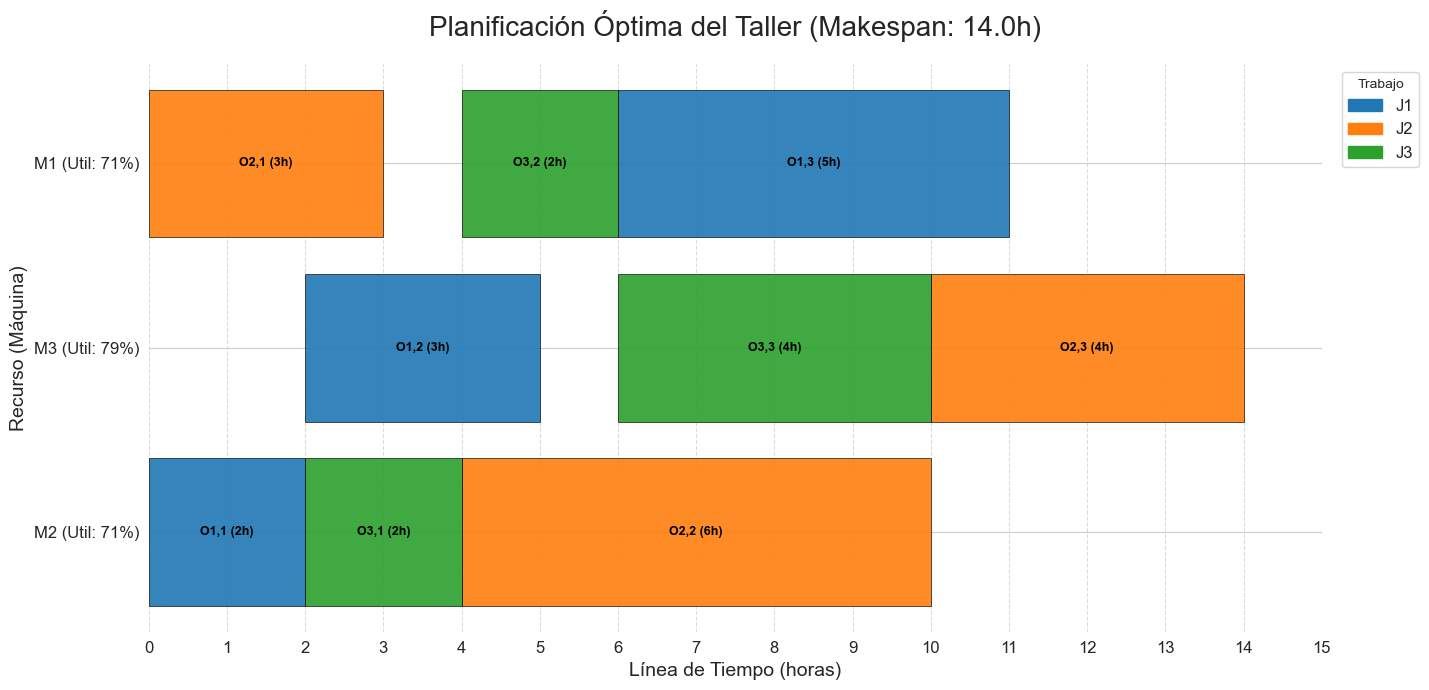

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# --- 1. Pre-cálculo: Utilización de las máquinas ---
makespan = solver.ObjectiveValue()
machine_utilization = df_schedule_sorted.groupby('Máquina')['Duración'].sum()
utilization_percent = (machine_utilization / makespan * 100).round(0).astype(int)

# --- 2. Configuración del Gráfico ---
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16, 7))

# --- 3. Paleta de Colores y Mapeo ---
color_palette = "tab10"
unique_jobs = sorted(df_schedule_sorted['Trabajo'].unique())
colors = sns.color_palette(color_palette, n_colors=len(unique_jobs))
color_map = dict(zip(unique_jobs, colors))

# --- 4. Dibujar las Barras ---
for index, row in df_schedule_sorted.iterrows():
    ax.barh(
        y=row['Máquina'], 
        width=row['Duración'], 
        left=row['Inicio'], 
        color=color_map[row['Trabajo']],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.9
    )
    label_text = f"{row['Operación']} ({row['Duración']}h)"
    ax.text(
        x=row['Inicio'] + row['Duración'] / 2, 
        y=row['Máquina'], 
        s=label_text, 
        ha='center', 
        va='center',
        color='black',
        fontsize=9,
        fontweight='bold'
    )

# Configuracion ddel formato de la grafica
ax.set_title(f"Planificación Óptima del Taller (Makespan: {makespan}h)", fontsize=20, pad=20)
ax.set_xlabel("Línea de Tiempo (horas)", fontsize=14)
ax.set_ylabel("Recurso (Máquina)", fontsize=14)

y_ticks_positions = sorted(df_schedule_sorted['Máquina'].unique())
y_tick_labels = [f"{machine} (Util: {utilization_percent.get(machine, 0)}%)" for machine in y_ticks_positions]

ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(y_tick_labels)

ax.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True) 

plt.xticks(range(0, int(makespan) + 2))
ax.tick_params(axis='both', which='major', labelsize=12)

legend_patches = [mpatches.Patch(color=color, label=job) for job, color in color_map.items()]
ax.legend(handles=legend_patches, title='Trabajo', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('../Images/ganttDetallado.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.3.2. Diagrama de Gantt enfocado solo en visualizar los trabajos (J1, J2 y J3)
Se presenta una versión simplificada del diagrama de Gantt. En esta visualización, se ha eliminado el detalle de la operación y la duración de cada barra para centrar la atención exclusivamente en qué **trabajo** se está ejecutando en cada máquina y en qué momento.

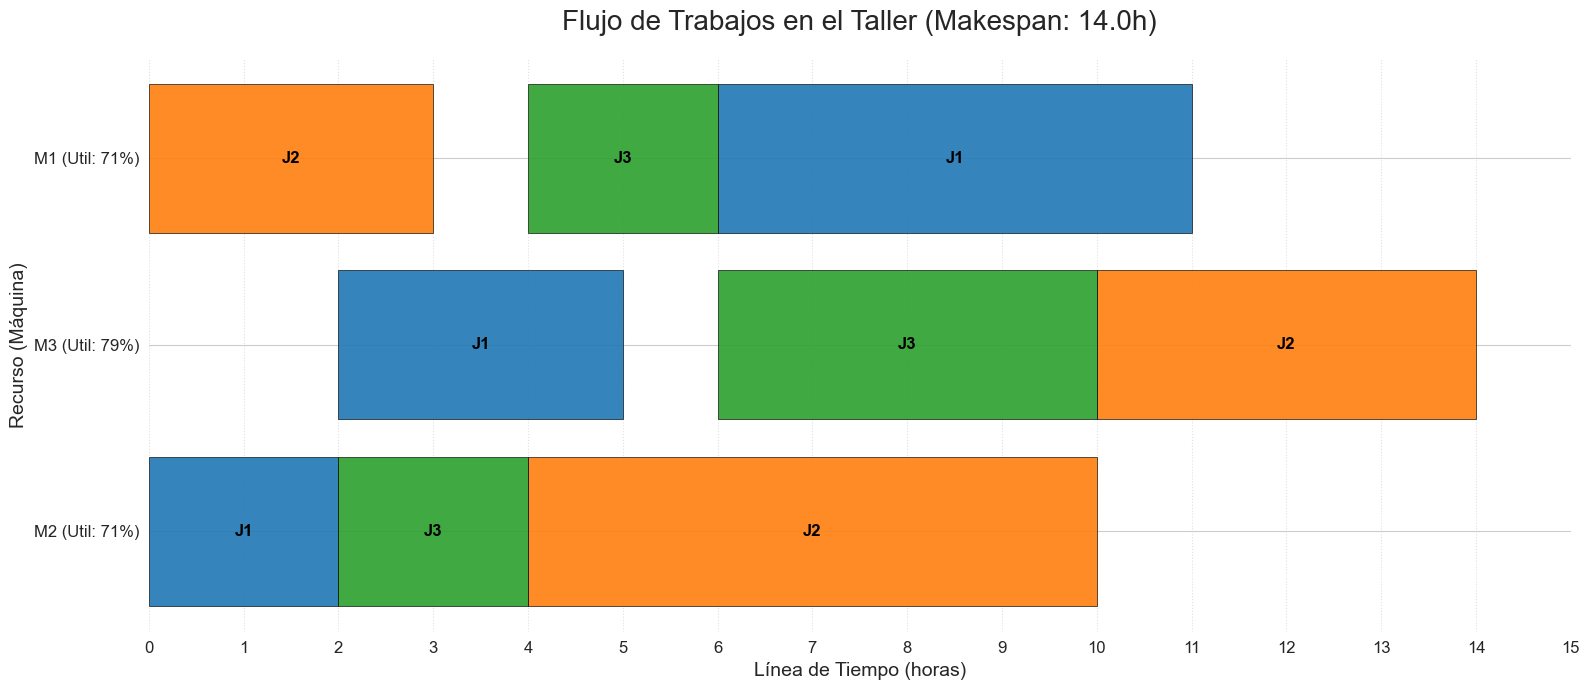

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16, 7))

color_palette = "tab10"
unique_jobs = sorted(df_schedule_sorted['Trabajo'].unique())
colors = sns.color_palette(color_palette, n_colors=len(unique_jobs))
color_map = dict(zip(unique_jobs, colors))

for index, row in df_schedule_sorted.iterrows():

    ax.barh(
        y=row['Máquina'], 
        width=row['Duración'], 
        left=row['Inicio'], 
        color=color_map[row['Trabajo']],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.9
    )
    ax.text(
        x=row['Inicio'] + row['Duración'] / 2, 
        y=row['Máquina'], 
        s=row['Trabajo'],  
        ha='center', 
        va='center',
        color='black',
        fontsize=12,
        fontweight='bold'
    )

# Configuracion ddel formato de la grafica
ax.set_title(f"Flujo de Trabajos en el Taller (Makespan: {solver.ObjectiveValue()}h)", fontsize=20, pad=20)
ax.set_xlabel("Línea de Tiempo (horas)", fontsize=14)
ax.set_ylabel("Recurso (Máquina)", fontsize=14)

y_ticks_positions = sorted(df_schedule_sorted['Máquina'].unique())
y_tick_labels = [f"{machine} (Util: {utilization_percent.get(machine, 0)}%)" for machine in y_ticks_positions]
ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(y_tick_labels)

ax.grid(axis='x', linestyle=':', alpha=0.6) 
sns.despine(left=True, bottom=True)

plt.xticks(range(0, int(solver.ObjectiveValue()) + 2))
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('../Images/ganttLimpio.png', dpi=300, bbox_inches='tight')
plt.show()


## Fase 4: Conclusión Numérica del Análisis

El análisis y la optimización del problema de planificación de 3 trabajos y 3 máquinas han concluido con la obtención de resultados cuantitativos precisos. El modelo determinó que el tiempo total de producción mínimo posible (makespan óptimo) para completar todas las tareas es de **14.0 horas**.

Durante este ciclo de producción de 14 horas, la utilización de los recursos fue desigual. La **Máquina 3** se identificó como el recurso más crítico, acumulando un total de **11 horas de trabajo**, lo que equivale a una utilización del **78.6%**. Por su parte, la **Máquina 1** y la **Máquina 2** operaron durante **10 horas** cada una, representando una utilización idéntica del **71.4%**. Consecuentemente, los tiempos de inactividad dentro del ciclo productivo fueron de 3 horas para la Máquina 3 y de 4 horas para las Máquinas 1 y 2. El plan de producción finaliza en la hora 14 con la última operación (`O2,3`) terminando su proceso en la Máquina 3, consolidando a esta última como el recurso que determina la duración total del proyecto.

---

Emiliano Rodriguez Villegas

Por ultimo convertimos el notebook a un script .py con la finalidad de portabilidad y facilidad para compartir, mayor limpieza en el codigo y el versionamiento de el.

In [113]:
! python ../convertidor.py --input ../Notebooks/ClassicJobShop.ipynb --output ClassicJobShop.py

[NbConvertApp] Converting notebook ../Notebooks/ClassicJobShop.ipynb to script
[NbConvertApp] Writing 17048 bytes to ..\Notebooks\ClassicJobShop.py
